In [ ]:
# !pip install kaggle xgboost

In [1]:
import os, json, hashlib, random, warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import joblib
import shap
import xgboost as xgb

In [2]:
def ensure_dir(p):
  Path(p).mkdir(parents=True, exist_ok=True)

ensure_dir('data')
ensure_dir('figs')
ensure_dir('artifacts')

def download_kaggle_house_prices():
    """Download the House Prices dataset via Kaggle API or kagglehub fallback."""
    ensure_dir('data')
    try:
        from kaggle.api.kaggle_api_extended import KaggleApi
        api = KaggleApi()
        print("Downloading dataset from Kaggle competition...")
        api.competition_download_file('house-prices-advanced-regression-techniques', 'train.csv', path='data')
        api.competition_download_file('house-prices-advanced-regression-techniques', 'test.csv', path='data')

        for f in os.listdir('data'):
            if f.endswith('.zip'):
                import zipfile
                with zipfile.ZipFile(os.path.join('data', f), 'r') as z:
                    z.extractall('data')
        print("Download complete: files saved to ./data")
    except Exception as e:
        print(f"Kaggle API failed, trying kagglehub fallback. Error: {e}")
        try:
            import kagglehub, shutil
            path = kagglehub.dataset_download("rishitaverma02/house-prices-advanced-regression-techniques")
            print("Downloaded via kagglehub to:", path)
            for item in os.listdir(path):
                src = os.path.join(path, item)
                dst = os.path.join('data', item)
                shutil.copy(src, dst)
            print("Files moved to ./data")
        except Exception as e2:
            print("Could not download dataset from either source. Please download manually from Kaggle.")
            print("Final error:", e2)

In [3]:
download_kaggle_house_prices()

Kaggle API failed, trying kagglehub fallback. Error: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
Downloaded via kagglehub to: /root/.cache/kagglehub/datasets/rishitaverma02/house-prices-advanced-regression-techniques/versions/1
Files moved to ./data


In [4]:
train_file = Path('data/train (1).csv')
if not train_file.exists():
    raise FileNotFoundError("train.csv missing in ./data after download attempt.")

df = pd.read_csv(train_file)
if 'Id' in df.columns:
    df = df.drop(columns=['Id'])

print("Loaded:", df.shape)

Loaded: (1460, 80)


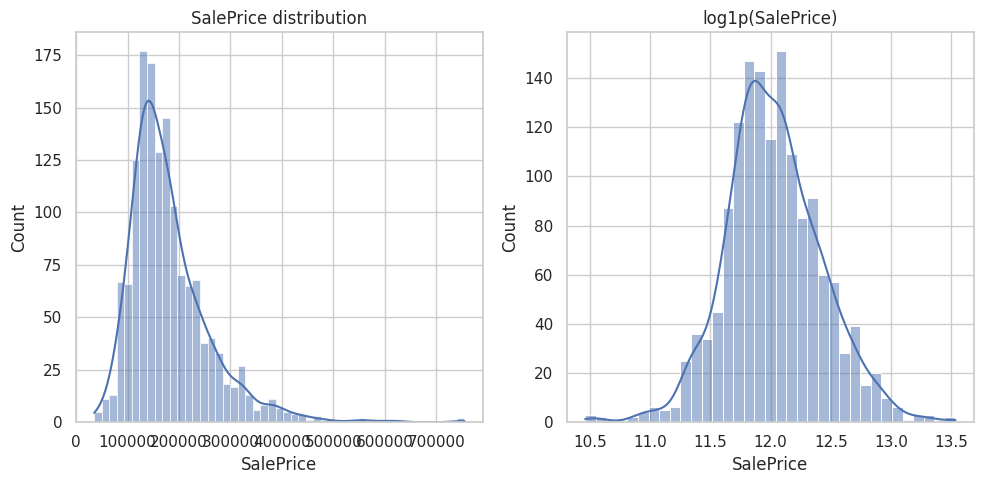

In [5]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(df['SalePrice'], kde=True)
plt.title('SalePrice distribution')
plt.subplot(1,2,2)
sns.histplot(np.log1p(df['SalePrice']), kde=True)
plt.title('log1p(SalePrice)')
plt.tight_layout()
plt.savefig('figs/price_distributions.png')

In [6]:
missing = df.isna().sum().sort_values(ascending=False)
missing_top = missing.head(20)
print("Top missing columns:\n", missing_top)


Top missing columns:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageType        81
GarageFinish      81
GarageCond        81
GarageYrBlt       81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtFinType1      37
BsmtCond          37
MasVnrArea         8
Electrical         1
BldgType           0
dtype: int64


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


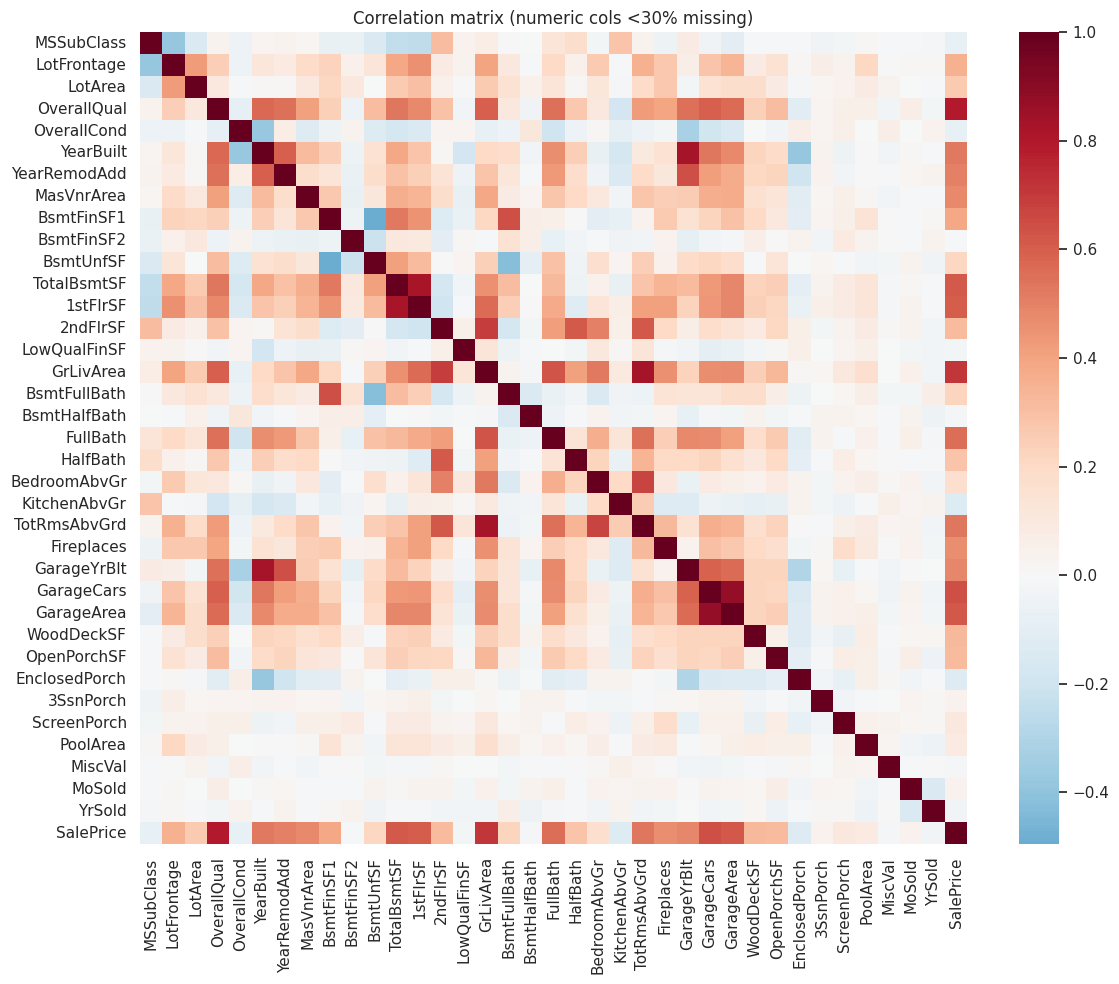

In [7]:
num = df.select_dtypes(include=[np.number]).copy()
num = num.loc[:, num.isna().mean() < 0.3]
corr = num.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='RdBu_r', center=0)
plt.title('Correlation matrix (numeric cols <30% missing)')
plt.tight_layout()
plt.savefig('figs/corr_matrix.png')
corr

In [8]:
df_base = df.copy()
df_base = df_base.dropna(subset=['SalePrice'])
df_base['log_price'] = np.log1p(df_base['SalePrice'])

numeric_cols = df_base.select_dtypes(include=[np.number]).columns.drop(['SalePrice','log_price'], errors='ignore').tolist()
categorical_cols = df_base.select_dtypes(include=['object','category']).columns.tolist()

X = df_base[numeric_cols + categorical_cols]
y = df_base['log_price']

X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X, y, test_size=0.15, random_state=42)


In [9]:
num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')), ('ohe', OneHotEncoder(handle_unknown='ignore'))])
preproc_base = ColumnTransformer([('num', num_pipe, numeric_cols), ('cat', cat_pipe, categorical_cols)])

pipe_ridge_base = Pipeline([('pre', preproc_base), ('model', Ridge(alpha=1.0, random_state=42))])
pipe_ridge_base.fit(X_train_b, y_train_b)

y_val_pred_log = pipe_ridge_base.predict(X_val_b)
y_val_pred = np.expm1(y_val_pred_log)
y_val_true = np.expm1(y_val_b)

print("Pre-localization Ridge validation metrics:")
print("RMSE (NGN):", np.sqrt(mean_squared_error(y_val_true, y_val_pred)))
print("MAE (NGN):", mean_absolute_error(y_val_true, y_val_pred))
print("R2 (log):", r2_score(y_val_b, y_val_pred_log))

Pre-localization Ridge validation metrics:
RMSE (NGN): 23301.096616795883
MAE (NGN): 15127.271526264485
R2 (log): 0.9165854337334678


In [29]:
from sklearn.utils.validation import check_is_fitted

check_is_fitted(pipe_ridge_base)

num_features_out = pipe_ridge_base.named_steps['pre'].transformers_[0][2]
try:
    ohe = pipe_ridge_base.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
    cat_features_out = list(ohe.get_feature_names_out(pipe_ridge_base.named_steps['pre'].transformers_[1][2]))
except Exception:
    cat_features_out = []

feature_names_base = num_features_out + cat_features_out
perm = permutation_importance(pipe_ridge_base, X_val_b, y_val_b, n_repeats=5, random_state=42)

# Ensure both arrays match in length
n = min(len(feature_names_base), len(perm.importances_mean))
perm_df = pd.DataFrame({
    'feature': feature_names_base[:n],
    'importance': perm.importances_mean[:n]
}).sort_values('importance', ascending=False).reset_index(drop=True)

top_k = 20
top_perm = perm_df.head(top_k)['feature'].tolist()
print("Top permutation features (pre-localization):")
print(perm_df.head(top_k))

Top permutation features (pre-localization):
                 feature  importance
0            OverallQual    0.060112
1              GrLivArea    0.051140
2          Alley_MISSING    0.033815
3       MSZoning_C (all)    0.027202
4            OverallCond    0.024250
5               1stFlrSF    0.020592
6              YearBuilt    0.018567
7               2ndFlrSF    0.017939
8             GarageCars    0.009827
9        LandContour_HLS    0.007413
10              PoolArea    0.007039
11      LotConfig_Inside    0.006227
12  Neighborhood_NPkVill    0.005831
13          YearRemodAdd    0.005282
14          BsmtFullBath    0.005267
15   Neighborhood_NWAmes    0.005218
16            Alley_Pave    0.004834
17   Neighborhood_BrDale    0.004597
18  Neighborhood_BrkSide    0.004214
19              FullBath    0.003929


In [30]:
X_val_trans = preproc_base.transform(X_val_b)
explainer = shap.Explainer(pipe_ridge_base.named_steps['model'], X_val_trans)
shap_vals = explainer(X_val_trans)
shap_mean = np.abs(shap_vals.values).mean(axis=0)
shap_df = pd.DataFrame({'feature': feature_names_base, 'mean_abs_shap': shap_mean}).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)
print("Top SHAP features (pre-localization):")
print(shap_df.head(top_k))

Top SHAP features (pre-localization):
             feature  mean_abs_shap
0        OverallQual       0.056089
1          GrLivArea       0.048747
2          YearBuilt       0.034594
3           2ndFlrSF       0.033724
4           1stFlrSF       0.030043
5        OverallCond       0.028681
6         GarageCars       0.025036
7       BsmtFullBath       0.019531
8   Foundation_PConc       0.017239
9         MSSubClass       0.016939
10   RoofStyle_Gable       0.016745
11       MSZoning_RL       0.016605
12       SaleType_WD       0.015990
13      YearRemodAdd       0.014960
14          HalfBath       0.014229
15        GarageArea       0.014039
16     RoofStyle_Hip       0.013899
17      HeatingQC_Ex       0.013021
18    Functional_Typ       0.012554
19          FullBath       0.012125


In [31]:
core_features_set = list(dict.fromkeys(top_perm + shap_df.head(top_k)['feature'].tolist()))
core_features_set = core_features_set[:top_k]
print("Selected core features (pre-localization):", core_features_set)

Selected core features (pre-localization): ['OverallQual', 'GrLivArea', 'Alley_MISSING', 'MSZoning_C (all)', 'OverallCond', '1stFlrSF', 'YearBuilt', '2ndFlrSF', 'GarageCars', 'LandContour_HLS', 'PoolArea', 'LotConfig_Inside', 'Neighborhood_NPkVill', 'YearRemodAdd', 'BsmtFullBath', 'Neighborhood_NWAmes', 'Alley_Pave', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'FullBath']


In [32]:
ibadan_neighs = ['Agbowo','Bodija','GRA','Moniya','Ojoo','Sango','IbadanNorth']
def map_to_ibadan(nbh):
    if pd.isna(nbh) or str(nbh).lower() == "nan":
        return 'Unknown'
    h = int(hashlib.md5(str(nbh).encode('utf-8')).hexdigest()[:8], 16)
    return ibadan_neighs[h % len(ibadan_neighs)]

if 'Neighborhood' in df.columns:
    df['ibadan_neighborhood'] = df['Neighborhood'].astype(str).apply(map_to_ibadan)
else:
    df['ibadan_neighborhood'] = [random.choice(ibadan_neighs) for _ in range(len(df))]

neigh_distance_map = {'Agbowo':1.2,'Bodija':3.5,'GRA':2.5,'Moniya':12.0,'Ojoo':18.0,'Sango':22.0,'IbadanNorth':8.0,'Unknown':15.0}
np.random.seed(42)
df['distance_to_ui_km'] = df['ibadan_neighborhood'].map(neigh_distance_map) + np.random.normal(0,0.6,size=len(df))
df['distance_to_ui_km'] = df['distance_to_ui_km'].clip(lower=0.1)
df['flood_risk'] = ((df['distance_to_ui_km'] < 5).astype(int) * np.random.choice([0,1], p=[0.7,0.3], size=len(df)))
power_score = {'Agbowo':0.9,'Bodija':0.7,'GRA':0.65,'Moniya':0.5,'Ojoo':0.4,'Sango':0.35,'IbadanNorth':0.6,'Unknown':0.5}
df['power_reliability'] = df['ibadan_neighborhood'].map(power_score) + np.random.normal(0,0.05,size=len(df))
df['power_reliability'] = df['power_reliability'].clip(0,1)

df['price'] = df['SalePrice'].astype(float)
df['log_price'] = np.log1p(df['price'])
CURRENT_YEAR = 2025
if 'YearBuilt' in df.columns:
    df['age'] = CURRENT_YEAR - df['YearBuilt']
else:
    df['age'] = np.random.randint(0,80,size=len(df))

if 'GrLivArea' in df.columns:
    df['price_per_sqm'] = df['price'] / (df['GrLivArea'] + 1)
else:
    df['price_per_sqm'] = df['price'] / (df['LotArea'] + 1)

if 'BedroomAbvGr' in df.columns and 'FullBath' in df.columns:
    df['bed_bath_ratio'] = df['BedroomAbvGr'] / (df['FullBath'] + 0.5)
else:
    df['bed_bath_ratio'] = np.random.rand(len(df))

eng_feats = ['distance_to_ui_km','flood_risk','power_reliability','age','price_per_sqm','bed_bath_ratio']

selected_core_raw = []
for f in core_features_set:
    if f in numeric_cols:
        selected_core_raw.append(f)
    else:
        if '_' in f:
            base = f.split('_')[0]
            if base in df.columns:
                selected_core_raw.append(base)
        else:
            if f in df.columns:
                selected_core_raw.append(f)
selected_core_raw = list(dict.fromkeys([c for c in selected_core_raw if c in df.columns]))

final_features = selected_core_raw + eng_feats
final_features = [f for f in final_features if f in df.columns]
print("Final features for modeling (core + ibadan):", final_features)


Final features for modeling (core + ibadan): ['OverallQual', 'GrLivArea', 'Alley', 'MSZoning', 'OverallCond', '1stFlrSF', 'YearBuilt', '2ndFlrSF', 'GarageCars', 'LandContour', 'PoolArea', 'LotConfig', 'Neighborhood', 'YearRemodAdd', 'BsmtFullBath', 'FullBath', 'distance_to_ui_km', 'flood_risk', 'power_reliability', 'age', 'price_per_sqm', 'bed_bath_ratio']


In [33]:
X_ib = df[final_features].copy()
y_ib = df['log_price'].copy()

X_train, X_val, y_train, y_val = train_test_split(X_ib, y_ib, test_size=0.15, random_state=42)

num_features_ib = X_ib.select_dtypes(include=[np.number]).columns.tolist()
cat_features_ib = X_ib.select_dtypes(include=['object','category']).columns.tolist()

num_pipe_ib = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipe_ib = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')), ('ohe', OneHotEncoder(handle_unknown='ignore'))])
preproc_ib = ColumnTransformer([('num', num_pipe_ib, num_features_ib), ('cat', cat_pipe_ib, cat_features_ib)])

pipe_ridge_ib = Pipeline([('pre', preproc_ib), ('model', Ridge(alpha=1.0, random_state=42))])
pipe_ridge_ib.fit(X_train, y_train)
y_pred_log_ridge = pipe_ridge_ib.predict(X_val)
y_pred_ridge = np.expm1(y_pred_log_ridge)
y_true = np.expm1(y_val)

print("\nRidge (Ibadan) metrics:")
print("RMSE (NGN):", np.sqrt(mean_squared_error(y_true, y_pred_ridge)))
print("MAE (NGN):", mean_absolute_error(y_true, y_pred_ridge))
print("R2 (log):", r2_score(y_val, y_pred_log_ridge))


Ridge (Ibadan) metrics:
RMSE (NGN): 28288.50978565836
MAE (NGN): 11483.424836530223
R2 (log): 0.9556497031808532


In [36]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=4, random_state=42,
                             predictor='gpu_predictor', tree_method='hist')
pipe_xgb_ib = Pipeline([('pre', preproc_ib), ('model', xgb_model)])

param_dist = {
    'model__n_estimators': [200, 400, 800],
    'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'model__max_depth': [3,5,7],
    'model__subsample': [0.7,0.8,1.0],
    'model__colsample_bytree': [0.5,0.7,1.0],
}

rnd = RandomizedSearchCV(pipe_xgb_ib, param_distributions=param_dist, n_iter=20, cv=3, scoring='neg_root_mean_squared_error', random_state=42, verbose=1)
rnd.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['OverallQual',
                                                                                'GrLivArea',
                                                                                'OverallCond',
                                                                                '1stFlrSF',
                                                                                'YearBuilt',
                                                                                '2ndFlrSF',
                                                                                'GarageCars',
                                                                                'PoolArea',
                                                                                'YearRemodAdd',
                                                                                'BsmtFullBath',
                                                                                'FullBath',
                                                                                'distance_to_ui_km',
                                                                                'fl...
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=4,
                                                           num_parallel_tree=None, ...))]),
                   n_iter=20,
                   param_distributions={'model__colsample_bytree': [0.5, 0.7,
                                                                    1.0],
                                        'model__learning_rate': [0.01, 0.03,
                                                                 0.05, 0.1],
                                        'model__max_depth': [3, 5, 7],
                                        'model__n_estimators': [200, 400, 800],
                                        'model__subsample': [0.7, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [37]:
np.sqrt(86747219.80693415)

np.float64(9313.818755319116)

In [43]:
best_model = rnd.best_estimator_
y_pred_log_xgb = best_model.predict(X_val)
y_pred_xgb = np.expm1(y_pred_log_xgb)

print("\nXGBoost (Ibadan) metrics:")
print("RMSE (NGN):", round(np.sqrt(mean_squared_error(y_true, y_pred_xgb)), 2))
print("MAE (NGN):", round(mean_absolute_error(y_true, y_pred_xgb), 2))
print("R2 (log):", r2_score(y_val, y_pred_log_xgb))


XGBoost (Ibadan) metrics:
RMSE (NGN): 10224.86
MAE (NGN): 4644.27
R2 (log): 0.9905854600905436


TreeExplainer failed (could not convert string to float: '[1.2027585E1]'), falling back to model-agnostic mode.
Computing SHAP values... this may take a moment ⏳


PermutationExplainer explainer: 1242it [02:00,  9.69it/s]                          


SHAP values computed successfully
Saved SHAP summary plot → fig_shap_beeswarm.png
Saved SHAP feature importance → shap_feature_importance.csv

🔝 Top 10 Features by SHAP Importance:
                feature  mean_abs_shap
1        num__GrLivArea       0.221964
15   num__price_per_sqm       0.186215
0      num__OverallQual       0.028352
3         num__1stFlrSF       0.018292
5         num__2ndFlrSF       0.010817
6       num__GarageCars       0.006472
4        num__YearBuilt       0.004460
2      num__OverallCond       0.003457
9     num__BsmtFullBath       0.001993
16  num__bed_bath_ratio       0.001281


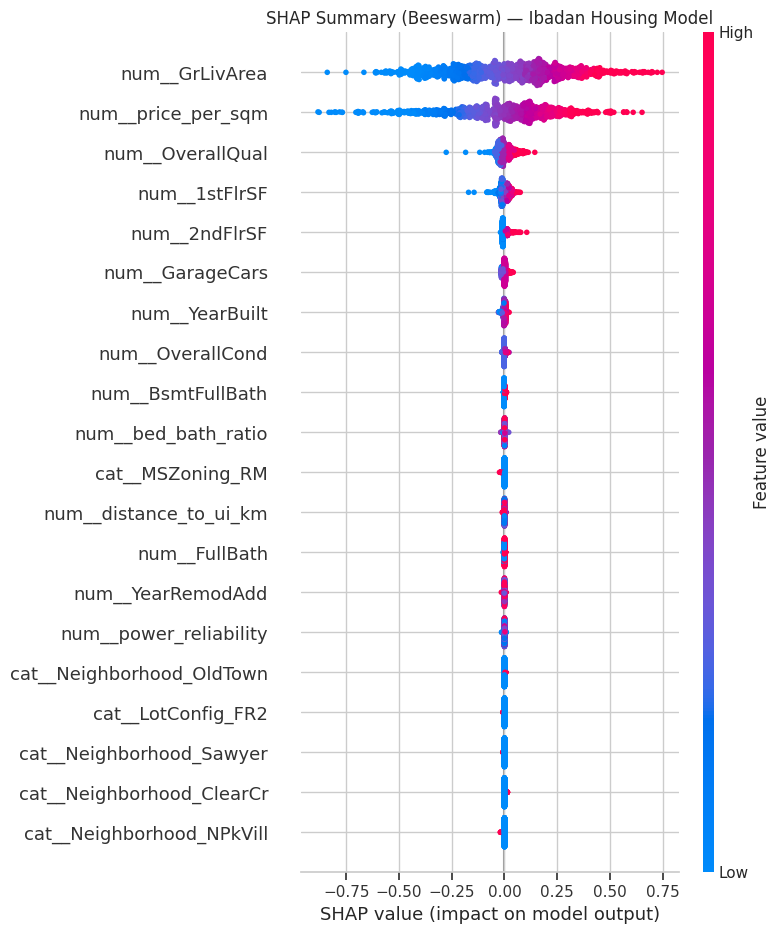

In [44]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

preprocessor = best_model.named_steps['pre']
xgb_final = best_model.named_steps['model']

X_train_trans = preprocessor.transform(X_train)
feature_names = preprocessor.get_feature_names_out()

try:
    booster = xgb_final.get_booster()
    base_score_attr = booster.attr('base_score')
    if isinstance(base_score_attr, str):
        # Convert string like "[1.2027585E1]" → "12.027585"
        clean_val = base_score_attr.strip('[]')
        booster.set_attr(base_score=str(float(clean_val)))
        print(f"Patched base_score from {base_score_attr} → {clean_val}")
except Exception as e:
    print(f"Could not patch base_score automatically: {e}")

try:
    explainer = shap.TreeExplainer(xgb_final)
except Exception as e:
    print(f"TreeExplainer failed ({e}), falling back to model-agnostic mode.")
    explainer = shap.Explainer(xgb_final.predict, X_train_trans)


print("Computing SHAP values... this may take a moment ⏳")
shap_values = explainer(X_train_trans)
print("SHAP values computed successfully")

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_trans, feature_names=feature_names, show=False)
plt.title("SHAP Summary (Beeswarm) — Ibadan Housing Model")
plt.tight_layout()
plt.savefig("fig_shap_beeswarm.png", bbox_inches="tight")
print("Saved SHAP summary plot → fig_shap_beeswarm.png")


importance_df = (
    pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap": np.abs(shap_values.values).mean(axis=0)
    })
    .sort_values(by="mean_abs_shap", ascending=False)
)
importance_df.to_csv("shap_feature_importance.csv", index=False)
print("Saved SHAP feature importance → shap_feature_importance.csv")

print("\n🔝 Top 10 Features by SHAP Importance:")
print(importance_df.head(10))



Top SHAP features:
                       feature  mean_abs_shap
1              num__GrLivArea       0.221964
15         num__price_per_sqm       0.186215
0            num__OverallQual       0.028352
3               num__1stFlrSF       0.018292
5               num__2ndFlrSF       0.010817
6             num__GarageCars       0.006472
4              num__YearBuilt       0.004460
2            num__OverallCond       0.003457
9           num__BsmtFullBath       0.001993
16        num__bed_bath_ratio       0.001281
24           cat__MSZoning_RM       0.001254
11     num__distance_to_ui_km       0.001063
10              num__FullBath       0.000917
8           num__YearRemodAdd       0.000855
13     num__power_reliability       0.000764
51  cat__Neighborhood_OldTown       0.000500
31         cat__LotConfig_FR2       0.000328
53   cat__Neighborhood_Sawyer       0.000328
38  cat__Neighborhood_ClearCr       0.000283
47  cat__Neighborhood_NPkVill       0.000271
Saved fig_shap_top15.png


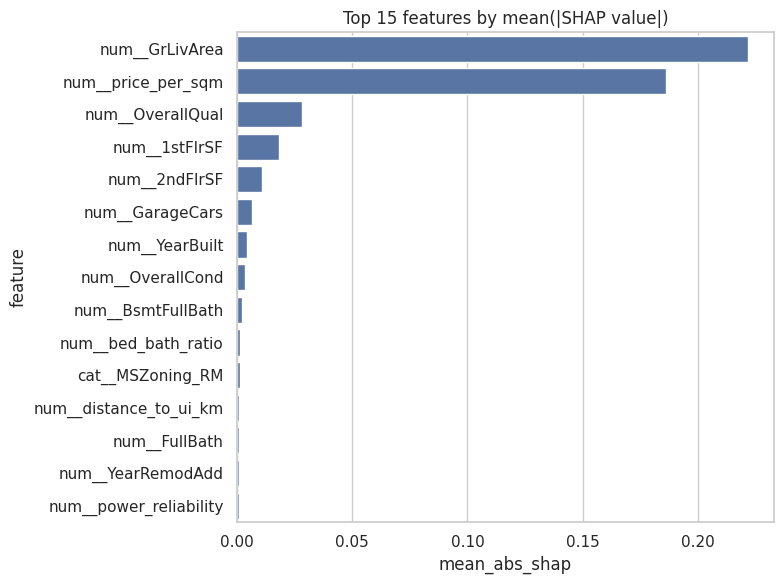

In [45]:
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({'feature': feature_names, 'mean_abs_shap': shap_abs_mean}).sort_values('mean_abs_shap', ascending=False)
print("\nTop SHAP features:\n", shap_df.head(20))

plt.figure(figsize=(8,6))
sns.barplot(y='feature', x='mean_abs_shap', data=shap_df.head(15))
plt.title('Top 15 features by mean(|SHAP value|)')
plt.tight_layout()
plt.savefig('fig_shap_top15.png')
print("Saved fig_shap_top15.png")

In [55]:
joblib.dump(best_model, 'artifacts/best_model_pipeline.joblib')
joblib.dump(preprocessor, 'artifacts/preprocessor.joblib')
joblib.dump(xgb_final, 'artifacts/xgb_raw_model.joblib')
joblib.dump(xgb_model, 'artifacts/xgb_base_model.joblib')
print("Saved artifacts to ./artifacts")

Saved artifacts to ./artifacts


In [56]:
best_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['OverallQual', 'GrLivArea',
                                                   'OverallCond', '1stFlrSF',
                                                   'YearBuilt', '2ndFlrSF',
                                                   'GarageCars', 'PoolArea',
                                                   'YearRemodAdd',
                                                   'BsmtFullBath', 'FullBath',
                                                   'distance_to_ui_km',
                                                   'flood_risk',
                                                   'power_reliability', 'age...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=400, n_jobs=4,
                              num_parallel_tree=None, ...))])